In [ ]:
%cd  /content/cnn_emotion/

[Errno 2] No such file or directory: '/content/cnn_emotion/'
/content


In [ ]:
!cp "/content/drive/My Drive/dataset.zip" /content/

In [ ]:
%cd "/content/cnn_emotion"
!unzip dataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: dataset/Sad/4597.jpg    
  inflating: dataset/Sad/4604.jpg    
  inflating: dataset/Sad/4610.jpg    
  inflating: dataset/Sad/4612.jpg    
  inflating: dataset/Sad/4615.jpg    
  inflating: dataset/Sad/4616.jpg    
  inflating: dataset/Sad/4623.jpg    
  inflating: dataset/Sad/4625.jpg    
  inflating: dataset/Sad/463.jpg     
  inflating: dataset/Sad/4648.jpg    
  inflating: dataset/Sad/4660.jpg    
  inflating: dataset/Sad/4663.jpg    
  inflating: dataset/Sad/4668.jpg    
  inflating: dataset/Sad/467.jpg     
  inflating: dataset/Sad/4678.jpg    
  inflating: dataset/Sad/4685.jpg    
  inflating: dataset/Sad/4687.jpg    
  inflating: dataset/Sad/4698.jpg    
  inflating: dataset/Sad/4704.jpg    
  inflating: dataset/Sad/4706.jpg    
  inflating: dataset/Sad/4715.jpg    
  inflating: dataset/Sad/4721.jpg    
  inflating: dataset/Sad/4730.jpg    
  inflating: dataset/Sad/4735.jpg    
  inflating: dataset/Sad/4737.jpg    
  inflating: dataset/Sa

# **1 数据预处理**

## 1.1 加载数据

In [ ]:
import numpy as np
import argparse
import cv2
from PIL import Image

def rotate(image, angle, center=None, scale=1.0):
    # 获取图像尺寸
    (h, w) = image.shape[:2]
 
    # 若未指定旋转中心，则将图像中心设为旋转中心
    if center is None:
        center = (w / 2, h / 2)
 
    # 执行旋转
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
 
    # 返回旋转后的图像
    return rotated



In [ ]:
# -*- coding: utf-8 -*-

# import the necessary packages
import numpy as np
import cv2
import os
import random

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose = 500, grayscale = False):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			if grayscale:
				image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			if(random.random()>0.9):
				image1 = image
				rotated = rotate(image1,random.randint(-15,15))
				data.append(rotated)
				labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))
				print("数据长度",len(data))
		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

## 1.2处理数据

In [ ]:
# -*- coding: utf-8 -*-

'''
process data
'''

import cv2

class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation 
        #method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect ratio
		return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [ ]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# 全局变量
dataset_path = 'images'
accuracy_plot_path = 'plots/accuracy.png'
loss_plot_path = 'plots/loss.png'
output_model_path = 'models/face_expression.hdf5'

# 全局常量
TARGET_IMAGE_WIDTH = 48
TARGET_IMAGE_HEIGHT = 48


# initialize the image preprocessor and datasetloader
sp = SimplePreprocessor(TARGET_IMAGE_WIDTH, TARGET_IMAGE_HEIGHT)
sdl = SimpleDatasetLoader(preprocessors=[sp])

# Load images
print("[INFO] 导入图像...")
image_paths = list(paths.list_images(dataset_path)) # path included
(X, y) = sdl.load(image_paths, verbose=500, grayscale = True)

# Flatten (reshape the data matrix)
# convert from (13164,TARGET_IMAGE_WIDTH,TARGET_IMAGE_HEIGHT) 
#into (13164,TARGET_IMAGE_WIDTH*TARGET_IMAGE_HEIGHT)
X = X.reshape((X.shape[0], TARGET_IMAGE_WIDTH*TARGET_IMAGE_HEIGHT)) 
X = X.astype("float") / 255.0 # 特征缩放，是非常重要的步骤

# Show some information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB"
      .format(X.nbytes / (1024 * 1024.0)))

# Label encoder
le = LabelEncoder()
y = to_categorical(le.fit_transform(y), 7)
print(le.classes_)

# 拆分数据集
(X_train, X_test, y_train, y_test) = train_test_split(X, y,test_size=0.25,random_state=42)

[INFO] 导入图像...
[INFO] processed 500/35887
数据长度 556
[INFO] processed 1000/35887
数据长度 1096
[INFO] processed 1500/35887
数据长度 1640
[INFO] processed 2000/35887
数据长度 2187
[INFO] processed 2500/35887
数据长度 2735
[INFO] processed 3000/35887
数据长度 3278
[INFO] processed 3500/35887
数据长度 3824
[INFO] processed 4000/35887
数据长度 4364
[INFO] processed 4500/35887
数据长度 4911
[INFO] processed 5000/35887
数据长度 5462
[INFO] processed 5500/35887
数据长度 6007
[INFO] processed 6000/35887
数据长度 6562
[INFO] processed 6500/35887
数据长度 7118
[INFO] processed 7000/35887
数据长度 7670
[INFO] processed 7500/35887
数据长度 8209
[INFO] processed 8000/35887
数据长度 8748
[INFO] processed 8500/35887
数据长度 9278
[INFO] processed 9000/35887
数据长度 9827
[INFO] processed 9500/35887
数据长度 10379
[INFO] processed 10000/35887
数据长度 10923
[INFO] processed 10500/35887
数据长度 11470
[INFO] processed 11000/35887
数据长度 12022
[INFO] processed 11500/35887
数据长度 12563
[INFO] processed 12000/35887
数据长度 13112
[INFO] processed 12500/35887
数据长度 13662
[INFO] processed 13000/3

In [5]:
import math
import numpy as np
print(np.argmax([1,2,3,1,1,1]))
lists = 

2


Angry:生气了
Disguest:厌恶
Fear:害怕
Happy:开心
Neutral:正常
Sad:伤心
Surprise:惊讶

# **2模型建立**

## 2.1 LetNet

In [ ]:
# -*- coding: utf-8 -*-
'''
Convolutional Neural Network
'''

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import BatchNormalization,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
#from keras.layers import Dropout
from keras import backend as K


class LeNet:
    @staticmethod
    def build(input_shape_width, input_shape_height, classes, 
              weight_path = '', input_shape_depth = 3):
        '''
        weight_path: a .hdf5 file. If exists, we can load model.
        '''
        
        # initialize the model
        model = Sequential()
        
        input_shape = (input_shape_height, input_shape_width, 
                       input_shape_depth)
        # if we are using "channels first", update the input shape
        if K.image_data_format() == 'channels_first':
             input_shape = (input_shape_depth, input_shape_height, 
                            input_shape_width)
        
        # first Convolution + relu + pooling layer
        model.add(Conv2D(filters = 64, kernel_size = (5, 5), 
                         padding = 'same', input_shape = input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (3, 3), strides=(2, 2)))
        
        # second convolutional layer
        model.add(Conv2D(filters = 64, kernel_size = (5, 5), 
                         padding = 'same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

        model.add(Conv2D(filters = 128, kernel_size = (5, 5), 
                         padding = 'same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        
        # Flattening
        model.add(Flatten())
        
        model.add(Dropout(0.5))
        model.add(Dropout(0.5))
        model.add(Dropout(0.5))
        # Full connection
        model.add(Dense(units = 512))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dense(units = 512))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        # output layer
        model.add(Dense(units = classes))
        model.add(Activation('softmax'))
        
        if weight_path:
            model.load_weights(weight_path)
            
        # return the constructed network architecture
        return model


## 2.2 Google-Net

In [ ]:
from __future__ import print_function
import imageio
from PIL import Image
import numpy as np
import keras

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD


def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x

def Inception(x,nb_filter):
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)

    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1),name=None)

    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None)
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(1,1), padding='same',strides=(1,1),name=None)

    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1),name=None)

    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)

    return x

def GoogleNet():
    inpt = Input(shape=(48,48,1))
    #padding = 'same'，填充为(步长-1）/2,还可以用ZeroPadding2D((3,3))
    x = Conv2d_BN(inpt,64,(7,7),strides=(2,2),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Conv2d_BN(x,192,(3,3),strides=(1,1),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Inception(x,64)#256
    x = Inception(x,120)#480
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    x = Inception(x,128)#512
    x = Inception(x,128)
    x = Inception(x,128)
    x = Inception(x,132)#528 
    x = Inception(x,208)#832

    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Inception(x,208)
    x = Inception(x,256)#1024
    x = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(x)
    x = Flatten()(x)
    x = Dropout(0.05)(x)
    x = Dense(1000,activation='relu')(x)
  
    x = Dense(7,activation='softmax')(x)
    model = Model(inpt,x,name='inception')
    return model

## 2.3 VGG_16

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D
from keras.utils import plot_model
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
def VGG_16(class_num):   
    input_shape = (48,48,1) # RGB影像224x224（height,width,channel)

    # 使用序贯模型(sequential)来定义
    model = Sequential(name='vgg16-sequential')

    # 第1个卷积区块(block1)
    model.add(Conv2D(64,(3,3),padding='same',activation='relu',input_shape=input_shape,name='block1_conv1'))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu',name='block1_conv2'))
    model.add(MaxPool2D((2,2),strides=(2,2),name='block1_pool'))

    # 第2个卷积区块(block2)
    model.add(Conv2D(128,(3,3),padding='same',activation='relu',name='block2_conv1'))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu',name='block2_conv2'))
    model.add(MaxPool2D((2,2),strides=(2,2),name='block2_pool'))

    # 第3个区块(block3)
    model.add(Conv2D(256,(3,3),padding='same',activation='relu',name='block3_conv1'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu',name='block3_conv2'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu',name='block3_conv3'))
    model.add(MaxPool2D((2,2),strides=(2,2),name='block3_pool'))

    # 第4个区块(block4)
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block4_conv1'))
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block4_conv2'))
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block4_conv3'))
    model.add(MaxPool2D((2,2),strides=(2,2),name='block4_pool'))

    # 第5个区块(block5)
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block5_conv1'))
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block5_conv2'))
    model.add(Conv2D(512,(3,3),padding='same',activation='relu',name='block5_conv3'))
    model.add(MaxPool2D((2,2),strides=(2,2),name='block5_pool'))

    # 前馈全连接区块
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096,activation='relu',name='fc1'))
    model.add(Dense(4096,activation='relu',name='fc2'))
    model.add(Dense(7,activation='softmax',name='predictions'))
    return model

## 2.4 ResNet50

In [ ]:

#coding=utf-8
from keras.models import Model
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D
from keras.layers import add,Flatten
#from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D
from keras.optimizers import SGD
import numpy as np
def ResNet50():
  seed = 7
  np.random.seed(seed)
  
  def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):
      if name is not None:
          bn_name = name + '_bn'
          conv_name = name + '_conv'
      else:
          bn_name = None
          conv_name = None
  
      x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
      x = BatchNormalization(axis=3,name=bn_name)(x)
      return x
  
  def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):
      x = Conv2d_BN(inpt,nb_filter=nb_filter[0],kernel_size=(1,1),strides=strides,padding='same')
      x = Conv2d_BN(x, nb_filter=nb_filter[1], kernel_size=(3,3), padding='same')
      x = Conv2d_BN(x, nb_filter=nb_filter[2], kernel_size=(1,1), padding='same')
      if with_conv_shortcut:
          shortcut = Conv2d_BN(inpt,nb_filter=nb_filter[2],strides=strides,kernel_size=kernel_size)
          x = add([x,shortcut])
          return x
      else:
          x = add([x,inpt])
          return x
  
  inpt = Input(shape=(48,48,1))
  x = ZeroPadding2D((3,3))(inpt)
  x = Conv2d_BN(x,nb_filter=64,kernel_size=(3,3),strides=(2,2),padding='valid')
  x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
  
  x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3),strides=(1,1),with_conv_shortcut=True)
  x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[64,64,256],kernel_size=(3,3))
  
  x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
  x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[128,128,512],kernel_size=(3,3))
  
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[256,256,1024],kernel_size=(3,3))
  
  x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
  x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))
  x = Conv_Block(x,nb_filter=[512,512,2048],kernel_size=(3,3))
  x = AveragePooling2D(pool_size=(3,3))(x)
  x = Flatten()(x)
  x = Dense(7,activation='softmax')(x)
  
  model = Model(inputs=inpt,outputs=x)
  return model


# 训练数据

[INFO] 编译模型...
[INFO] 训练模型...
Train on 29540 samples, validate on 9847 samples
Epoch 1/200
29540/29540 [==============================] - 27s 927us/step - loss: 1.8518 - accuracy: 0.2672 - val_loss: 1.8890 - val_accuracy: 0.1713
Epoch 2/200
29540/29540 [==============================] - 20s 667us/step - loss: 1.6037 - accuracy: 0.3716 - val_loss: 1.9825 - val_accuracy: 0.1735
Epoch 3/200
29540/29540 [==============================] - 20s 667us/step - loss: 1.4603 - accuracy: 0.4357 - val_loss: 1.7948 - val_accuracy: 0.3320
Epoch 4/200
29540/29540 [==============================] - 20s 669us/step - loss: 1.3753 - accuracy: 0.4682 - val_loss: 1.5502 - val_accuracy: 0.4110
Epoch 5/200
29540/29540 [==============================] - 20s 667us/step - loss: 1.3105 - accuracy: 0.4980 - val_loss: 1.4455 - val_accuracy: 0.4317
Epoch 6/200
29540/29540 [==============================] - 20s 667us/step - loss: 1.2712 - accuracy: 0.5139 - val_loss: 1.3284 - val_accuracy: 0.4863
Epoch 7/200
29540/295

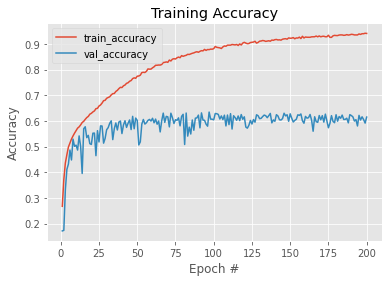

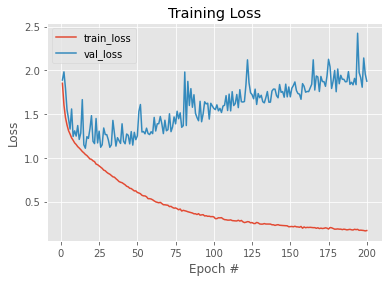

In [ ]:
# -*- coding: utf-8 -*-
'''
train mnist    
测试
image is grayscale with 28*28 size.
'''

# 导入包
# from lenet import LeNet
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization

# 全局常量
# LR = 0.01
BATCH_SIZE = 256
EPOCHS = 200

# 全局变量
accuracy_plot_path = 'plots/accuracy.png'
loss_plot_path = 'plots/loss.png'
output_model_path = 'models/mnist.hdf5'


((trainData, trainLabels), (testData, testLabels)) = (X_train,y_train),(X_test,y_test)
# print(trainData)
# print(trainLabels)

trainData = trainData.reshape((trainData.shape[0], 48, 48, 1))
testData = testData.reshape((testData.shape[0], 48, 48, 1))
# print(trainData)
# print(trainLabels)

# transform the training and testing labels into vectors 
#in the range [0, classes]
# trainLabels = np_utils.to_categorical(trainLabels, 7)
# testLabels = np_utils.to_categorical(testLabels, 7)


################################################3
# 第二部分：创建并训练模型
# initialize the optimizer and model
print('[INFO] 编译模型...')

opt = Adam(lr=0.001)
model = LeNet.build(48,48,7,'',1)
# model = VGG_16(7)
# model = GoogleNet()
model.compile(loss ='categorical_crossentropy', 
              optimizer=opt, metrics = ['accuracy'])

# train model
print('[INFO] 训练模型...')
H = model.fit(trainData, trainLabels, 
              validation_data=(testData, testLabels),
              batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1)


################################################
# 第三部分：评估模型

# 画出accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(1, EPOCHS+1), H.history["val_accuracy"],label="val_accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(accuracy_plot_path)

# 画出loss曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1,EPOCHS+1),H.history["loss"], label="train_loss")
plt.plot(np.arange(1,EPOCHS+1),H.history["val_loss"],label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig(loss_plot_path)

# 打印分类报告
# show accuracy on the testing set
print('[INFO] 评估模型...')
predictions = model.predict(testData, batch_size=256)
print(classification_report(testLabels.argmax(axis=1),
	                        predictions.argmax(axis=1), 
                            target_names=[str(i) for i in range(7)]))


################################################
# 第四部分：保存模型
model.save(output_model_path)
